<a href="https://colab.research.google.com/github/allicia21/mvp_segunda_sprint_lm/blob/master/aprovacao_emprestimos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. CONFIGURAÇÃO DO AMBIENTE

In [29]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

import joblib
from google.colab import files


# 2. CARGA DO DATASET

In [37]:
url = "https://raw.githubusercontent.com/allicia21/mvp_segunda_sprint_lm/refs/heads/master/avaliacaoEmprestismos.csv"

dataset = pd.read_csv(url, delimiter=',', nrows=5000)

dataset.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


3. SEPARAÇÃO DE FEATURES E TARGET

In [31]:
X = dataset.drop(columns=['loan_status'])
y = dataset['loan_status'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

categorical_features = ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
numeric_features = [col for col in X.columns if col not in categorical_features]

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', StandardScaler(), numeric_features)
])

 5. MODELOS PARA TESTE


Avaliação dos modelos com validação cruzada:

KNN: Média = 0.8766 | Desvio = 0.0082


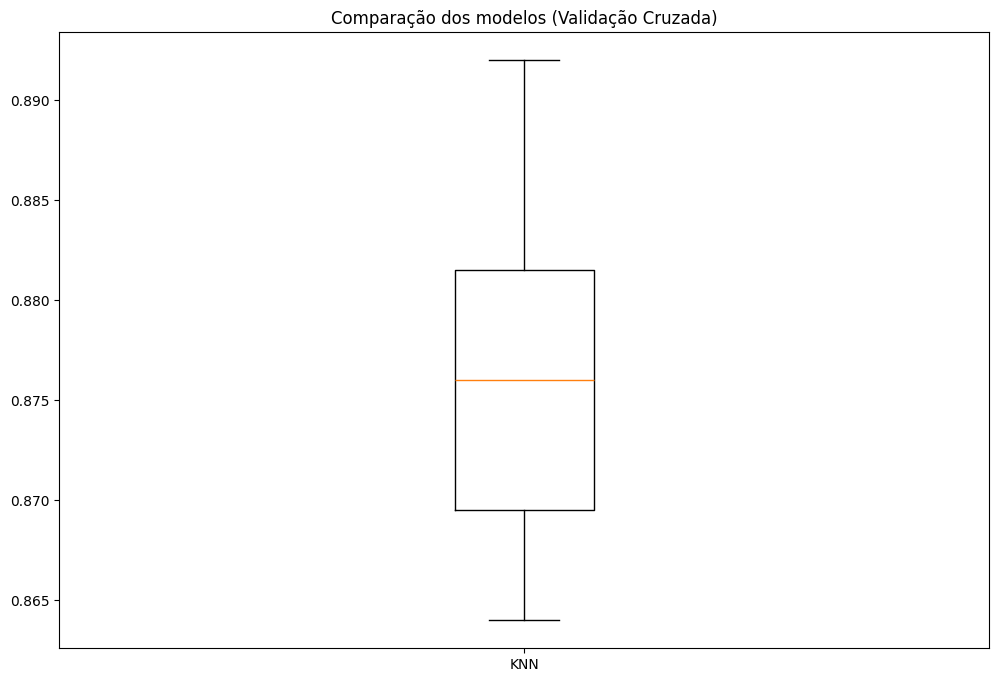

DecisionTree: Média = 0.8960 | Desvio = 0.0105


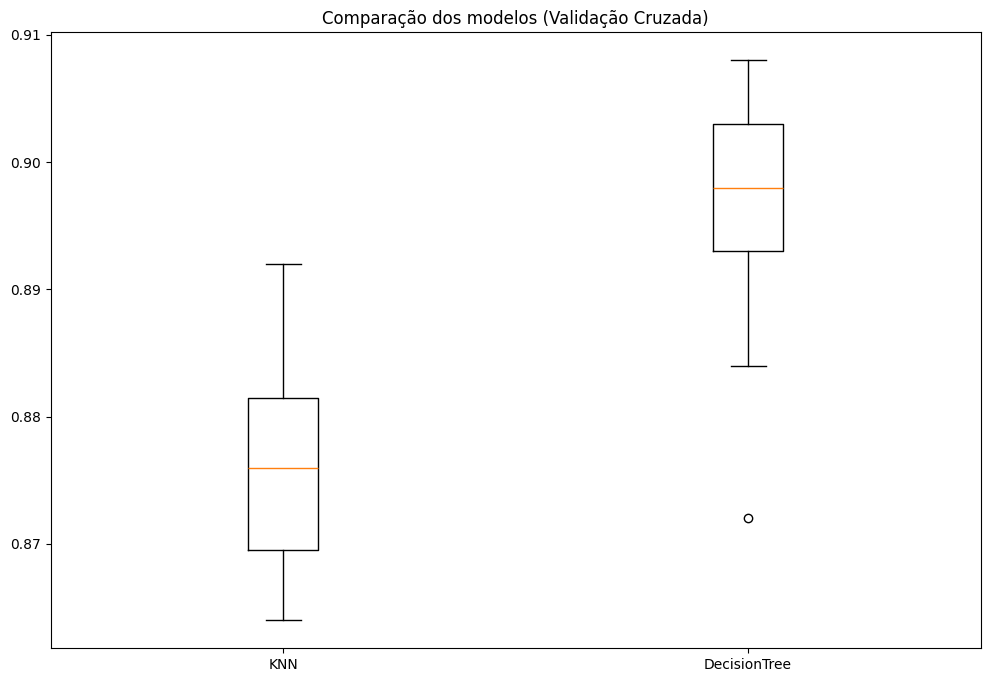

NaiveBayes: Média = 0.7678 | Desvio = 0.0104


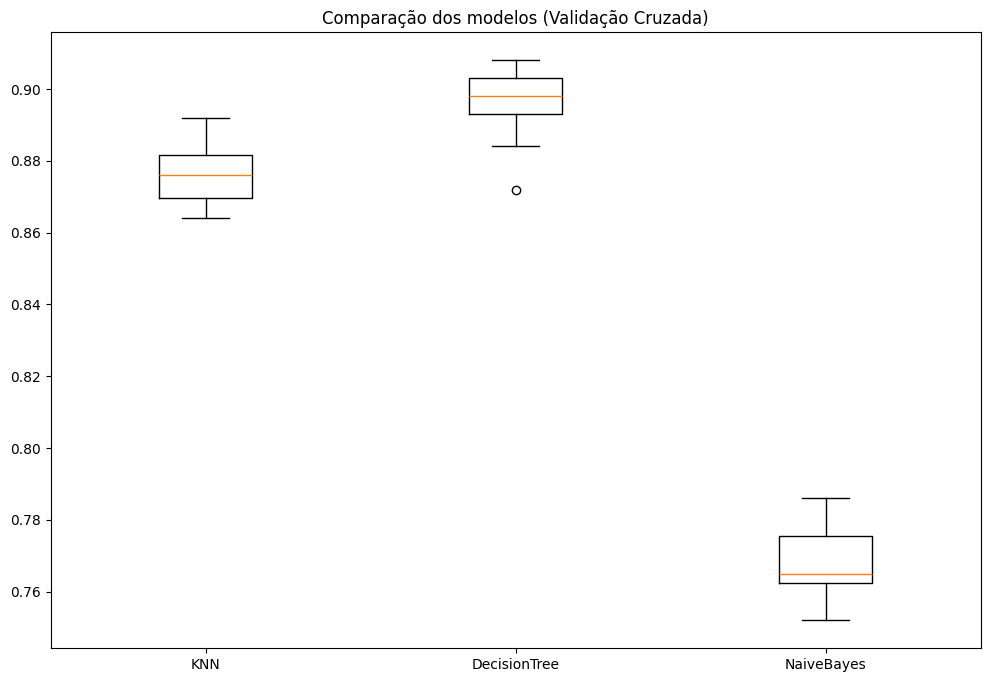

SVM: Média = 0.9098 | Desvio = 0.0101


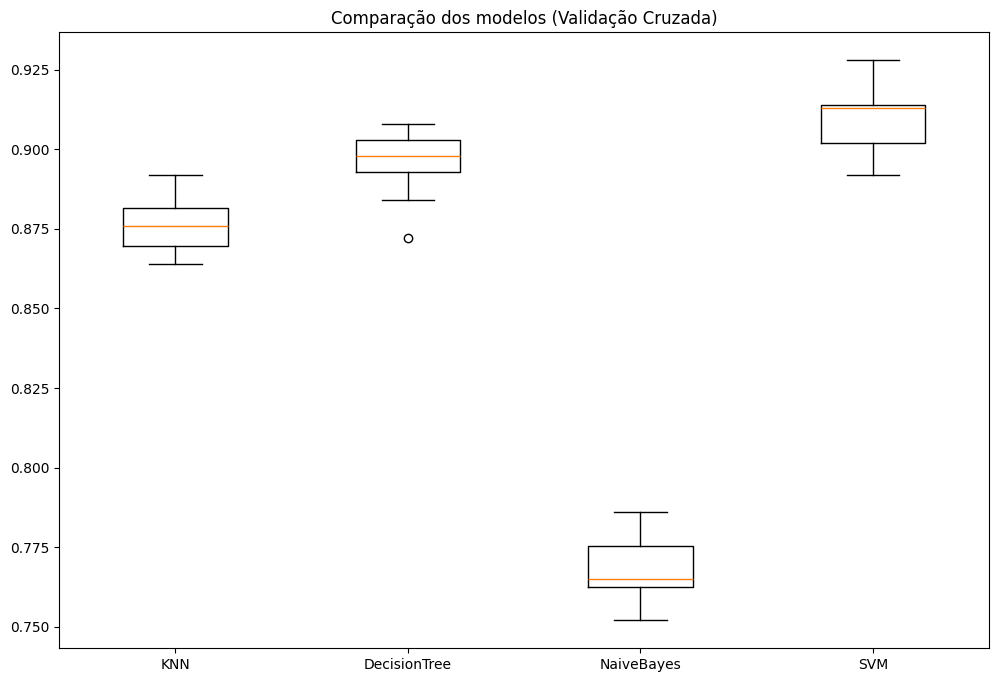

RandomForest: Média = 0.9228 | Desvio = 0.0102


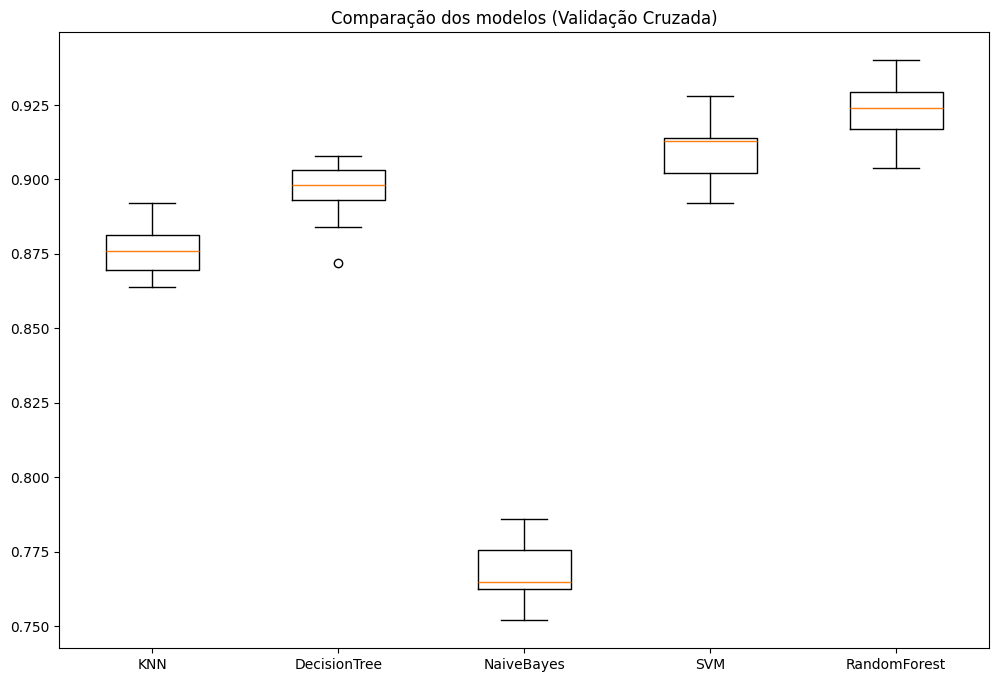

AdaBoost: Média = 0.9010 | Desvio = 0.0118


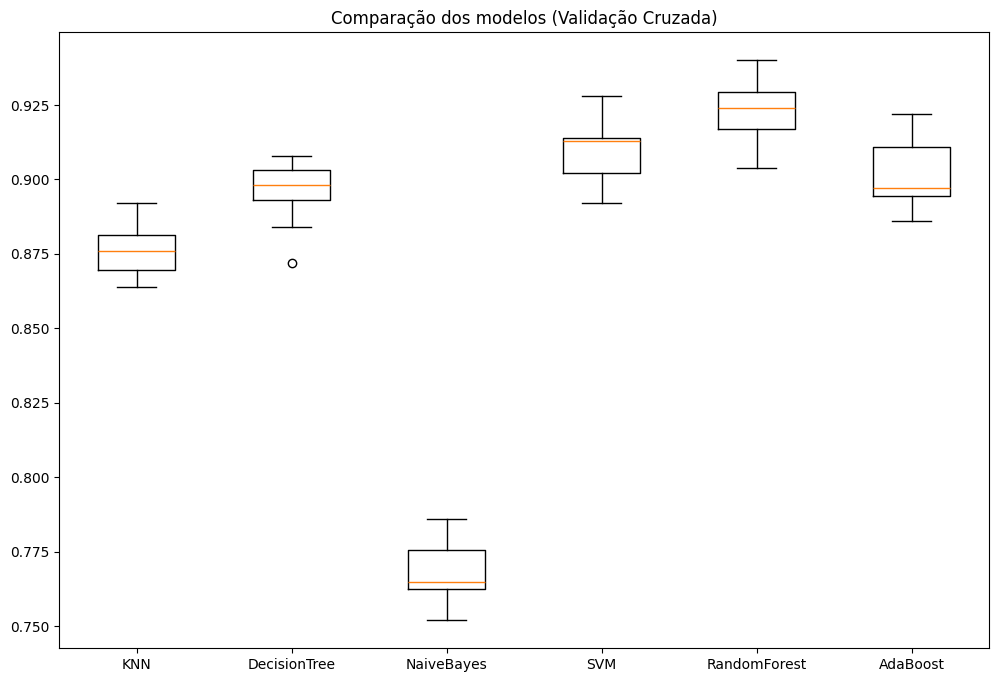

In [32]:
np.random.seed(7) # definindo uma semente global para este bloco

models = {
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(),
    'NaiveBayes': GaussianNB(),
    'SVM': SVC(),
    'RandomForest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier()
}

scoring = 'accuracy'
num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=7)

print("\nAvaliação dos modelos com validação cruzada:\n")
results = []
names = []

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    cv_results = cross_val_score(pipeline, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f"{name}: Média = {cv_results.mean():.4f} | Desvio = {cv_results.std():.4f}")

    # Boxplot para comparar modelos
    plt.figure(figsize=(12,8))
    plt.boxplot(results, labels=names)
    plt.title('Comparação dos modelos (Validação Cruzada)')
    plt.show()

 6. OTIMIZAÇÃO DE HIPERPARÂMETROS

In [33]:
# Random Forest otimizado (como melhor modelo final)
param_grid_rf = {
    'rf__n_estimators': [100, 150, 200],
    'rf__max_features': ['sqrt', 'log2']
}

pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(random_state=42))
])

grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=kfold, scoring=scoring)
grid_rf.fit(X_train, y_train)

print(f"\nMelhor Random Forest: {grid_rf.best_score_:.4f} com {grid_rf.best_params_}")


Melhor Random Forest: 0.9243 com {'rf__max_features': 'log2', 'rf__n_estimators': 200}


 7. AVALIAÇÃO FINAL NO CONJUNTO DE TESTE

In [34]:
best_rf_model = grid_rf.best_estimator_
y_pred = best_rf_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Acurácia final no teste com RF otimizado: {acc:.4f}")

Acurácia final no teste com RF otimizado: 0.9190


# 8 - Otimização dos Hiperparametros



In [35]:
# Hyperparameter optimization for KNN
param_grid_knn = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance']
}

pipeline_knn = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier())
])

grid_knn = GridSearchCV(pipeline_knn, param_grid_knn, cv=kfold, scoring=scoring)
grid_knn.fit(X_train, y_train)

print(f"\nMelhor KNN: {grid_knn.best_score_:.4f} com {grid_knn.best_params_}")

# Hyperparameter optimization for SVM
param_grid_svm = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf']
}

pipeline_svm = Pipeline([
    ('preprocessor', preprocessor),
    ('svm', SVC())
])

grid_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=kfold, scoring=scoring)
grid_svm.fit(X_train, y_train)

print(f"\nMelhor SVM: {grid_svm.best_score_:.4f} com {grid_svm.best_params_}")

# Hyperparameter optimization for Decision Tree
param_grid_dt = {
    'decisiontree__max_depth': [None, 10, 20, 30],
    'decisiontree__min_samples_split': [2, 5, 10]
}

pipeline_dt = Pipeline([
    ('preprocessor', preprocessor),
    ('decisiontree', DecisionTreeClassifier(random_state=42))
])

grid_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=kfold, scoring=scoring)
grid_dt.fit(X_train, y_train)

print(f"\nMelhor Decision Tree: {grid_dt.best_score_:.4f} com {grid_dt.best_params_}")

# Hyperparameter optimization for AdaBoost
param_grid_ab = {
    'adaboost__n_estimators': [50, 100, 150],
    'adaboost__learning_rate': [0.01, 0.1, 1]
}

pipeline_ab = Pipeline([
    ('preprocessor', preprocessor),
    ('adaboost', AdaBoostClassifier(random_state=42))
])

grid_ab = GridSearchCV(pipeline_ab, param_grid_ab, cv=kfold, scoring=scoring)
grid_ab.fit(X_train, y_train)

print(f"\nMelhor AdaBoost: {grid_ab.best_score_:.4f} com {grid_ab.best_params_}")


Melhor KNN: 0.8855 com {'knn__n_neighbors': 9, 'knn__weights': 'distance'}

Melhor SVM: 0.9073 com {'svm__C': 1, 'svm__kernel': 'rbf'}

Melhor Decision Tree: 0.9143 com {'decisiontree__max_depth': 10, 'decisiontree__min_samples_split': 5}

Melhor AdaBoost: 0.9098 com {'adaboost__learning_rate': 1, 'adaboost__n_estimators': 100}


#9 - Finalização do modelo

In [36]:
best_model_name = None
best_test_accuracy = 0

optimized_models = {
    'RandomForest': grid_rf.best_estimator_,
    'KNN': grid_knn.best_estimator_,
    'SVM': grid_svm.best_estimator_,
    'DecisionTree': grid_dt.best_estimator_,
    'AdaBoost': grid_ab.best_estimator_
}

print("\nAvaliação final dos modelos otimizados no conjunto de teste:\n")

for name, model in optimized_models.items():
    y_pred_test = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred_test)
    print(f"{name}: Acurácia no teste = {test_acc:.4f}")

    if test_acc > best_test_accuracy:
        best_test_accuracy = test_acc
        best_model_name = name

print(f"\nO melhor modelo com base na acurácia no conjunto de teste é: {best_model_name} com acurácia de {best_test_accuracy:.4f}")

# Retrain the best model on the full training data (X_train, y_train) to prepare for production
final_model = optimized_models[best_model_name]
# The best_estimator_ from GridSearchCV is already fitted on the training data.
# If you want to train on the full dataset (X, y), you would do:
# final_model = Pipeline([
#     ('preprocessor', preprocessor),
#     (best_model_name.lower(), optimized_models[best_model_name].named_steps[best_model_name.lower()])
# ])
# final_model.fit(X, y)
# However, using the best estimator from GridSearchCV is generally preferred for a production model
# as it represents the model and hyperparameters that performed best during cross-validation.

# Save the best model
model_filename = f'{best_model_name.lower()}_best_model.pkl'
joblib.dump(final_model, model_filename)

print(f"\nO melhor modelo ({best_model_name}) foi salvo em {model_filename}")

# Download the saved model file
#try:
    #files.download(model_filename)
    #print(f"\nArquivo '{model_filename}' baixado com sucesso.")
#except Exception as e:
    #print(f"\nErro ao baixar o arquivo '{model_filename}': {e}")
    #print("Por favor, verifique se a execução está sendo feita no Google Colab ou se houve algum outro problema.")



Avaliação final dos modelos otimizados no conjunto de teste:

RandomForest: Acurácia no teste = 0.9190
KNN: Acurácia no teste = 0.8770
SVM: Acurácia no teste = 0.9150
DecisionTree: Acurácia no teste = 0.9180
AdaBoost: Acurácia no teste = 0.9060

O melhor modelo com base na acurácia no conjunto de teste é: RandomForest com acurácia de 0.9190

O melhor modelo (RandomForest) foi salvo em randomforest_best_model.pkl
